# Neural Language Models

This notebook compares a fixed-context neural language model and a recurrent neural language model (RNN) on two local datasets.


In [1]:
import json
import time
import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset

from NLM import BasicNeuralLanguageModel
from ReccurentNLM import RNNNeuralLanguageModel
from nlp_pipeline import (
    Tokenizer,
    Vocabulary,
    loadNewsTexts,
    loadAmazonTexts,
    textsToTokenStream,
    trainValSplit,
    makeNgramXY,
    makeRnnXY,
    sampleXY,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)


## Load And Prepare Data

We load documents, tokenize them, build a vocabulary, and encode tokens into integer ids.


In [2]:
tokenizer = Tokenizer()

newsTexts = loadNewsTexts('data/News_Category_Dataset_v2.json', maxRows=7000)
amazonTexts = loadAmazonTexts('data/AmazonReviews/train.csv', maxRows=7000)

newsTokens = textsToTokenStream(newsTexts, tokenizer=tokenizer, maxTokens=90000)
amazonTokens = textsToTokenStream(amazonTexts, tokenizer=tokenizer, maxTokens=90000)

newsVocab = Vocabulary.fromTokens(newsTokens, maxVocab=1200, minFreq=2)
amazonVocab = Vocabulary.fromTokens(amazonTokens, maxVocab=1200, minFreq=2)

newsIds = newsVocab.encode(newsTokens)
amazonIds = amazonVocab.encode(amazonTokens)

print('news docs', len(newsTexts), 'tokens', len(newsTokens), 'vocab', len(newsVocab))
print('amazon docs', len(amazonTexts), 'tokens', len(amazonTokens), 'vocab', len(amazonVocab))


news docs 7000 tokens 90000 vocab 1200
amazon docs 7000 tokens 90000 vocab 1200


## Hyperparameters

The settings below are chosen to keep training small and fast.


In [3]:
contextSize = 4
seqLen = 20

maxNgramTrain = 12000
maxNgramVal = 3000
maxRnnTrain = 1200
maxRnnVal = 300

epochs = 3
embeddingDim = 32
hiddenDim = 64

lr = 3e-3
gradClip = 5.0


In [4]:
def preparePairs(tokenIds: np.ndarray):
    trainIds, valIds = trainValSplit(tokenIds, valRatio=0.1)

    ngramXTrain, ngramYTrain = makeNgramXY(trainIds, contextSize=contextSize)
    ngramXVal, ngramYVal = makeNgramXY(valIds, contextSize=contextSize)
    ngramXTrain, ngramYTrain = sampleXY(ngramXTrain, ngramYTrain, maxSamples=maxNgramTrain, seed=0)
    ngramXVal, ngramYVal = sampleXY(ngramXVal, ngramYVal, maxSamples=maxNgramVal, seed=1)

    rnnXTrain, rnnYTrain = makeRnnXY(trainIds, seqLen=seqLen, stride=seqLen)
    rnnXVal, rnnYVal = makeRnnXY(valIds, seqLen=seqLen, stride=seqLen)
    rnnXTrain, rnnYTrain = sampleXY(rnnXTrain, rnnYTrain, maxSamples=maxRnnTrain, seed=2)
    rnnXVal, rnnYVal = sampleXY(rnnXVal, rnnYVal, maxSamples=maxRnnVal, seed=3)

    return (trainIds, valIds), (ngramXTrain, ngramYTrain, ngramXVal, ngramYVal), (rnnXTrain, rnnYTrain, rnnXVal, rnnYVal)


## Training Utilities

We train with cross-entropy loss and report perplexity as `exp(loss)`.


In [5]:
@torch.no_grad()
def evalBasic(model, loader):
    model.eval()
    total = 0.0
    n = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        loss = model.loss(x, y)
        total += float(loss.item()) * int(x.size(0))
        n += int(x.size(0))
    return total / max(1, n)


@torch.no_grad()
def evalRnn(model, loader):
    model.eval()
    total = 0.0
    n = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        loss = model.loss(x, y)
        tokens = int(y.numel())
        total += float(loss.item()) * tokens
        n += tokens
    return total / max(1, n)


def trainBasic(model, trainLoader, valLoader):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = {'trainLoss': [], 'valLoss': [], 'trainPpl': [], 'valPpl': []}
    for _ in range(epochs):
        model.train()
        total = 0.0
        n = 0
        for x, y in trainLoader:
            x = x.to(device)
            y = y.to(device)
            opt.zero_grad(set_to_none=True)
            loss = model.loss(x, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradClip)
            opt.step()
            total += float(loss.item()) * int(x.size(0))
            n += int(x.size(0))
        trainLoss = total / max(1, n)
        valLoss = evalBasic(model, valLoader)
        hist['trainLoss'].append(trainLoss)
        hist['valLoss'].append(valLoss)
        hist['trainPpl'].append(float(math.exp(trainLoss)))
        hist['valPpl'].append(float(math.exp(valLoss)))
    return hist


def trainRnn(model, trainLoader, valLoader):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = {'trainLoss': [], 'valLoss': [], 'trainPpl': [], 'valPpl': []}
    for _ in range(epochs):
        model.train()
        total = 0.0
        n = 0
        for x, y in trainLoader:
            x = x.to(device)
            y = y.to(device)
            opt.zero_grad(set_to_none=True)
            loss = model.loss(x, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradClip)
            opt.step()
            tokens = int(y.numel())
            total += float(loss.item()) * tokens
            n += tokens
        trainLoss = total / max(1, n)
        valLoss = evalRnn(model, valLoader)
        hist['trainLoss'].append(trainLoss)
        hist['valLoss'].append(valLoss)
        hist['trainPpl'].append(float(math.exp(trainLoss)))
        hist['valPpl'].append(float(math.exp(valLoss)))
    return hist


## Text Generation

We generate by sampling the next token from the model distribution.


In [6]:
@torch.no_grad()
def generateBasic(model, startCtx, maxNewTokens=24, temperature=1.0, seed=0):
    g = torch.Generator(device=device)
    g.manual_seed(int(seed))
    model.eval()
    ctx = list(int(x) for x in startCtx)
    out = []
    for _ in range(int(maxNewTokens)):
        x = torch.tensor([ctx], dtype=torch.long, device=device)
        logits = model(x)[0] / float(temperature)
        probs = torch.softmax(logits, dim=-1)
        nxt = int(torch.multinomial(probs, num_samples=1, generator=g).item())
        out.append(nxt)
        ctx = ctx[1:] + [nxt]
    return out


@torch.no_grad()
def generateRnn(model, startTokens, maxNewTokens=24, temperature=1.0, seed=0):
    g = torch.Generator(device=device)
    g.manual_seed(int(seed))
    model.eval()
    h = None
    out = [int(t) for t in startTokens]
    for t in out[:-1]:
        x = torch.tensor([[t]], dtype=torch.long, device=device)
        _, h = model(x, h)
    cur = out[-1] if out else 0
    for _ in range(int(maxNewTokens)):
        x = torch.tensor([[cur]], dtype=torch.long, device=device)
        logits, h = model(x, h)
        logits = logits[0, -1] / float(temperature)
        probs = torch.softmax(logits, dim=-1)
        cur = int(torch.multinomial(probs, num_samples=1, generator=g).item())
        out.append(cur)
    return out


## Train And Compare

We train the Basic model and the RNN model on each dataset and compare validation perplexity.


In [7]:
def runDataset(name: str, tokenIds: np.ndarray, vocab: Vocabulary):
    (trainIds, _), (ngramXTrain, ngramYTrain, ngramXVal, ngramYVal), (rnnXTrain, rnnYTrain, rnnXVal, rnnYVal) = preparePairs(tokenIds)

    vocabSize = int(tokenIds.max()) + 1

    basic = BasicNeuralLanguageModel(vocabSize=vocabSize, contextSize=contextSize, embeddingDim=embeddingDim, hiddenDim=hiddenDim)
    rnn = RNNNeuralLanguageModel(vocabSize=vocabSize, embeddingDim=embeddingDim, hiddenDim=hiddenDim)

    basicTrain = DataLoader(TensorDataset(torch.from_numpy(ngramXTrain), torch.from_numpy(ngramYTrain)), batch_size=256, shuffle=True)
    basicVal = DataLoader(TensorDataset(torch.from_numpy(ngramXVal), torch.from_numpy(ngramYVal)), batch_size=256, shuffle=False)

    rnnTrain = DataLoader(TensorDataset(torch.from_numpy(rnnXTrain), torch.from_numpy(rnnYTrain)), batch_size=64, shuffle=True)
    rnnVal = DataLoader(TensorDataset(torch.from_numpy(rnnXVal), torch.from_numpy(rnnYVal)), batch_size=64, shuffle=False)

    t0 = time.time()
    basicHist = trainBasic(basic, basicTrain, basicVal)
    t1 = time.time()
    rnnHist = trainRnn(rnn, rnnTrain, rnnVal)
    t2 = time.time()

    basicValLoss = evalBasic(basic, basicVal)
    rnnValLoss = evalRnn(rnn, rnnVal)

    samples = {}
    if len(ngramXVal) > 0:
        startCtx = ngramXVal[0].tolist()
        genBasic = generateBasic(basic, startCtx, maxNewTokens=24, temperature=1.0, seed=1)
        samples['basicStart'] = vocab.decodeText(startCtx)
        samples['basicGen'] = vocab.decodeText(startCtx + genBasic)
    if len(rnnXVal) > 0:
        startTokens = rnnXVal[0][:6].tolist()
        genRnn = generateRnn(rnn, startTokens, maxNewTokens=24, temperature=1.0, seed=1)
        samples['rnnStart'] = vocab.decodeText(startTokens)
        samples['rnnGen'] = vocab.decodeText(genRnn)

    return {
        'dataset': name,
        'vocabSize': vocabSize,
        'basicTimeSec': float(t1 - t0),
        'rnnTimeSec': float(t2 - t1),
        'basicValLoss': float(basicValLoss),
        'rnnValLoss': float(rnnValLoss),
        'basicValPpl': float(math.exp(basicValLoss)),
        'rnnValPpl': float(math.exp(rnnValLoss)),
        'basicHistory': basicHist,
        'rnnHistory': rnnHist,
        'samples': samples,
    }


results = []
results.append(runDataset('news', newsIds, newsVocab))
results.append(runDataset('amazon', amazonIds, amazonVocab))

for r in results:
    print(r['dataset'], 'val perplexity', 'basic', round(r['basicValPpl'], 2), 'rnn', round(r['rnnValPpl'], 2))


news val perplexity basic 92.25 rnn 99.77
amazon val perplexity basic 133.21 rnn 161.92


## Plots


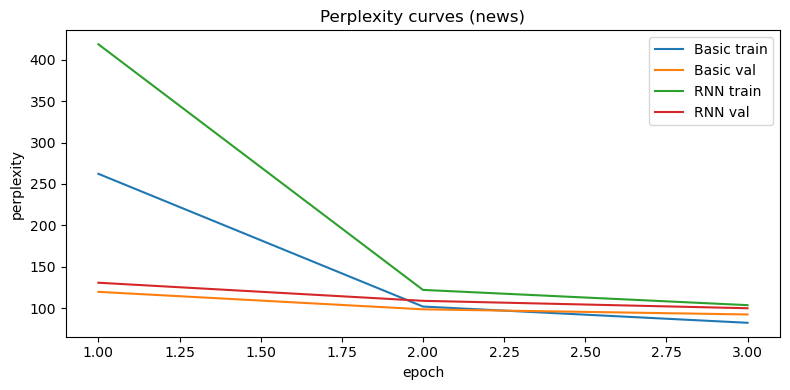

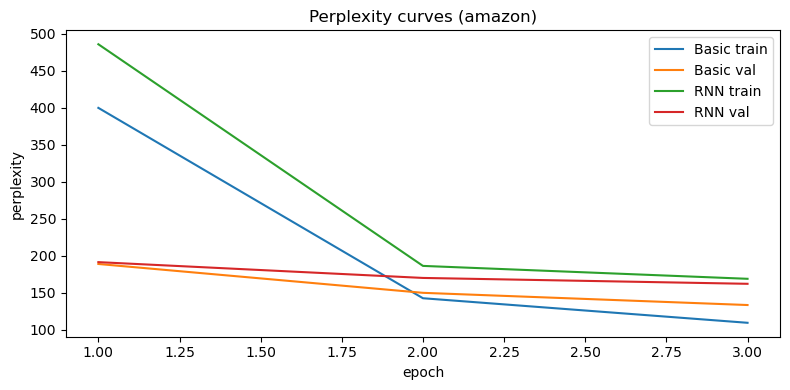

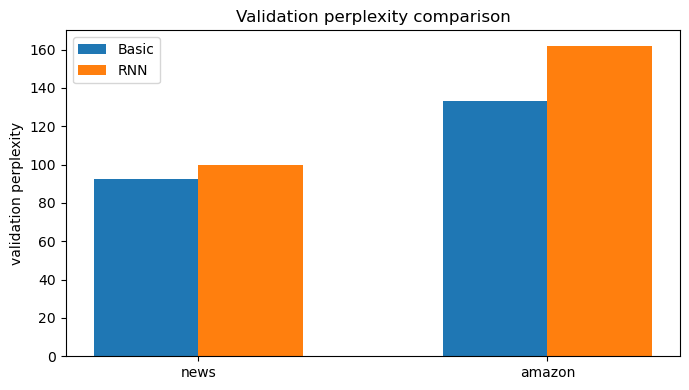

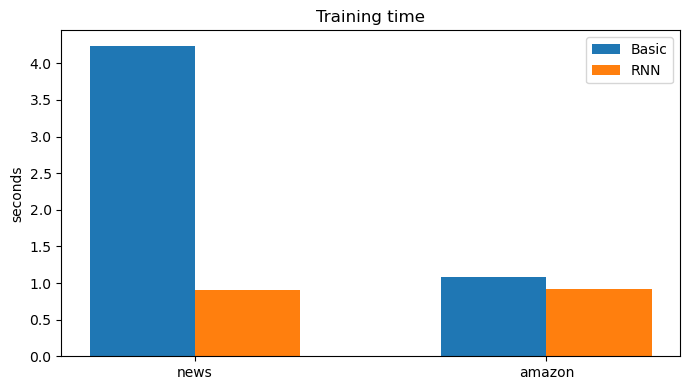

wrote latex/results.json, latex/results_table.tex, latex/outputs_ready.txt


In [8]:
Path('latex/figs').mkdir(parents=True, exist_ok=True)

for r in results:
    epochsAxis = list(range(1, len(r['basicHistory']['trainLoss']) + 1))
    plt.figure(figsize=(8, 4))
    plt.plot(epochsAxis, r['basicHistory']['trainPpl'], label='Basic train')
    plt.plot(epochsAxis, r['basicHistory']['valPpl'], label='Basic val')
    plt.plot(epochsAxis, r['rnnHistory']['trainPpl'], label='RNN train')
    plt.plot(epochsAxis, r['rnnHistory']['valPpl'], label='RNN val')
    plt.xlabel('epoch')
    plt.ylabel('perplexity')
    plt.title(f"Perplexity curves ({r['dataset']})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"latex/figs/{r['dataset']}_perplexity_curves.png", dpi=160)
    plt.show()

labels = [r['dataset'] for r in results]
basicVals = [r['basicValPpl'] for r in results]
rnnVals = [r['rnnValPpl'] for r in results]
x = np.arange(len(labels))

plt.figure(figsize=(7, 4))
plt.bar(x - 0.15, basicVals, width=0.3, label='Basic')
plt.bar(x + 0.15, rnnVals, width=0.3, label='RNN')
plt.xticks(x, labels)
plt.ylabel('validation perplexity')
plt.title('Validation perplexity comparison')
plt.legend()
plt.tight_layout()
plt.savefig('latex/figs/val_perplexity_comparison.png', dpi=160)
plt.show()

basicTimes = [r['basicTimeSec'] for r in results]
rnnTimes = [r['rnnTimeSec'] for r in results]

plt.figure(figsize=(7, 4))
plt.bar(x - 0.15, basicTimes, width=0.3, label='Basic')
plt.bar(x + 0.15, rnnTimes, width=0.3, label='RNN')
plt.xticks(x, labels)
plt.ylabel('seconds')
plt.title('Training time')
plt.legend()
plt.tight_layout()
plt.savefig('latex/figs/training_time_comparison.png', dpi=160)
plt.show()

out = {
    'hparams': {
        'contextSize': contextSize,
        'seqLen': seqLen,
        'epochs': epochs,
        'embeddingDim': embeddingDim,
        'hiddenDim': hiddenDim,
        'lr': lr,
        'gradClip': gradClip,
        'vocabMaxSize': 1200,
        'vocabMinFreq': 2,
        'maxRows': 7000,
        'maxTokens': 90000,
        'maxNgramTrain': maxNgramTrain,
        'maxNgramVal': maxNgramVal,
        'maxRnnTrain': maxRnnTrain,
        'maxRnnVal': maxRnnVal,
    },
    'results': results,
}

Path('latex').mkdir(parents=True, exist_ok=True)
Path('latex/results.json').write_text(json.dumps(out, indent=2), encoding='utf-8')

import subprocess
import sys
subprocess.run([sys.executable, 'latex/make_results_table.py'], check=True)

Path('latex/outputs_ready.txt').write_text('ok', encoding='utf-8')
print('wrote latex/results.json, latex/results_table.tex, latex/outputs_ready.txt')
